In [ ]:
import capytaine as cpt
import numpy as np
import xarray as xr
import os
from scipy.spatial.transform import Rotation as R 


rho_water = 1000.0
g         = 9.81

wave_dirs   = [np.pi]   # following seas
base_mesh = "0_5FlatAkterspeil"
trim_angles = [-3.45, -2.3, -1.15, 0, 1.15, 2.3]   # [deg] pitch about y-axis
#trim_angles = [-3.45, -2.3]


period = np.arange(0.5, 1.3, 0.05)  # [s]
omega_range = 2 * np.pi / period  # [rad/s]

#speeds      = [0.0, 0.5, 1.0, 1.5]
speeds      = [0.001, 0.6, 1, 1.4]  


os.makedirs("txt_summaries", exist_ok=True)

for angle in trim_angles:
    name = f"{base_mesh}_pitch{angle:+.2f}deg"
    print(f"\n=== Processing trim angle: {angle} deg ===")

    mesh   = cpt.load_mesh(f"{base_mesh}.stl")
    center = mesh.center_of_buoyancy


    rot = R.from_euler("y", angle, degrees=True)
    mesh.vertices = rot.apply(mesh.vertices - center) + center

    lid_mesh = mesh.generate_lid()
    body     = cpt.FloatingBody(
        mesh=mesh.immersed_part(),
        lid_mesh=lid_mesh,
        dofs=cpt.rigid_body_dofs(rotation_center=center),
    )
    body.show()
    body.center_of_mass   = center
    body.mass             = body.immersed_part().volume * rho_water
    body.inertia_matrix   = body.compute_rigid_body_inertia()
    hydrostatics          = body.compute_hydrostatics(rho=rho_water)

    coords   = {
        "omega":          omega_range,
        "forward_speed":  speeds,
        "wave_direction": wave_dirs,
        "water_depth":    [np.inf],
        "rho":            [rho_water],
        "radiating_dof":  list(body.dofs.keys()),
    }
    template = xr.Dataset(coords=coords)
    dataset  = cpt.BEMSolver().fill_dataset(template, body)
    if "forward_speed" not in dataset.dims:
        dataset = dataset.expand_dims({"forward_speed": speeds})
    if "wave_direction" not in dataset.dims:
        dataset = dataset.expand_dims({"wave_direction": wave_dirs})
    rao = cpt.post_pro.rao(dataset)



    txt1 = os.path.join("txt_summaries", f"{name}_added_damping.txt")
    with open(txt1, "w") as f:
        f.write(f"# Mesh: {name}\n\n")
        for U in speeds:
            f.write(f"## Forward speed: {U:.2f} m/s\n")
            for var, label in [
                ("added_mass",        "Added Mass"),
                ("radiation_damping", "Radiation Damping"),
            ]:
                f.write(f"{label}\n")
                da = dataset[var]
                # if somehow forward_speed was still squeezed, re-expand
                if "forward_speed" not in da.dims:
                    da = da.expand_dims({"forward_speed": speeds})
                daU = da.sel(forward_speed=U)
                for ω in omega_range:
                    mat = daU.sel(omega=ω).squeeze().values
                    for row in mat:
                        f.write(" ".join(f"{v:.6e}" for v in row) + "\n")
                    f.write("\n")
            f.write("---\n")

    txt2 = os.path.join("txt_summaries", f"{name}_forces.txt")
    with open(txt2, "w") as f:
        f.write(f"# Excitation forces for mesh {name}\n")
        da = dataset["excitation_force"]
        if "forward_speed" not in da.dims:
            da = da.expand_dims({"forward_speed": speeds})
        for U in speeds:
            f.write(f"\n# U={U:.2f} m/s\n")
            daU = da.sel(forward_speed=U)
            for wd in wave_dirs:
                daUW = daU.sel(wave_direction=wd)
                for ω in omega_range:
                    vec = daUW.sel(omega=ω).values
                    f.write(f"{ω:.3f} {wd:.3f} " +
                            " ".join(f"{v:.6e}" for v in vec) + "\n")

    txt3 = os.path.join("txt_summaries", f"{name}_rao.txt")
    with open(txt3, "w") as f:
        f.write(f"# RAO for mesh {name}\n")
        da = rao
        if "forward_speed" not in da.dims:
            da = da.expand_dims({"forward_speed": speeds})
        for U in speeds:
            f.write(f"\n# U={U:.2f} m/s\n")
            daU = da.sel(forward_speed=U)
            for wd in wave_dirs:
                daUW = daU.sel(wave_direction=wd)
                for ω in omega_range:
                    vec = daUW.sel(omega=ω).values
                    f.write(f"{ω:.3f} {wd:.3f} " +
                            " ".join(f"{abs(v):.6e}" for v in vec) + "\n")




=== Processing trim angle: -3.45 deg ===


[18:10:23] WARNING  Mesh resolution for 84 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 10.472 to 12.566.      
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()


=== Processing trim angle: -2.3 deg ===


[18:22:48] WARNING  Mesh resolution for 84 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 10.472 to 12.566.      
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()


=== Processing trim angle: -1.15 deg ===


[18:32:49] WARNING  Mesh resolution for 28 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 12.566 to 12.566.      
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()


=== Processing trim angle: 0 deg ===


Output()


=== Processing trim angle: 1.15 deg ===


Output()


=== Processing trim angle: 2.3 deg ===


Output()

['0_5FlatAkterspeil_pitch-3.45deg', '0_5FlatAkterspeil_pitch-2.30deg', '0_5FlatAkterspeil_pitch-1.15deg', '0_5FlatAkterspeil_pitch+0.00deg', '0_5FlatAkterspeil_pitch+1.15deg', '0_5FlatAkterspeil_pitch+2.30deg']


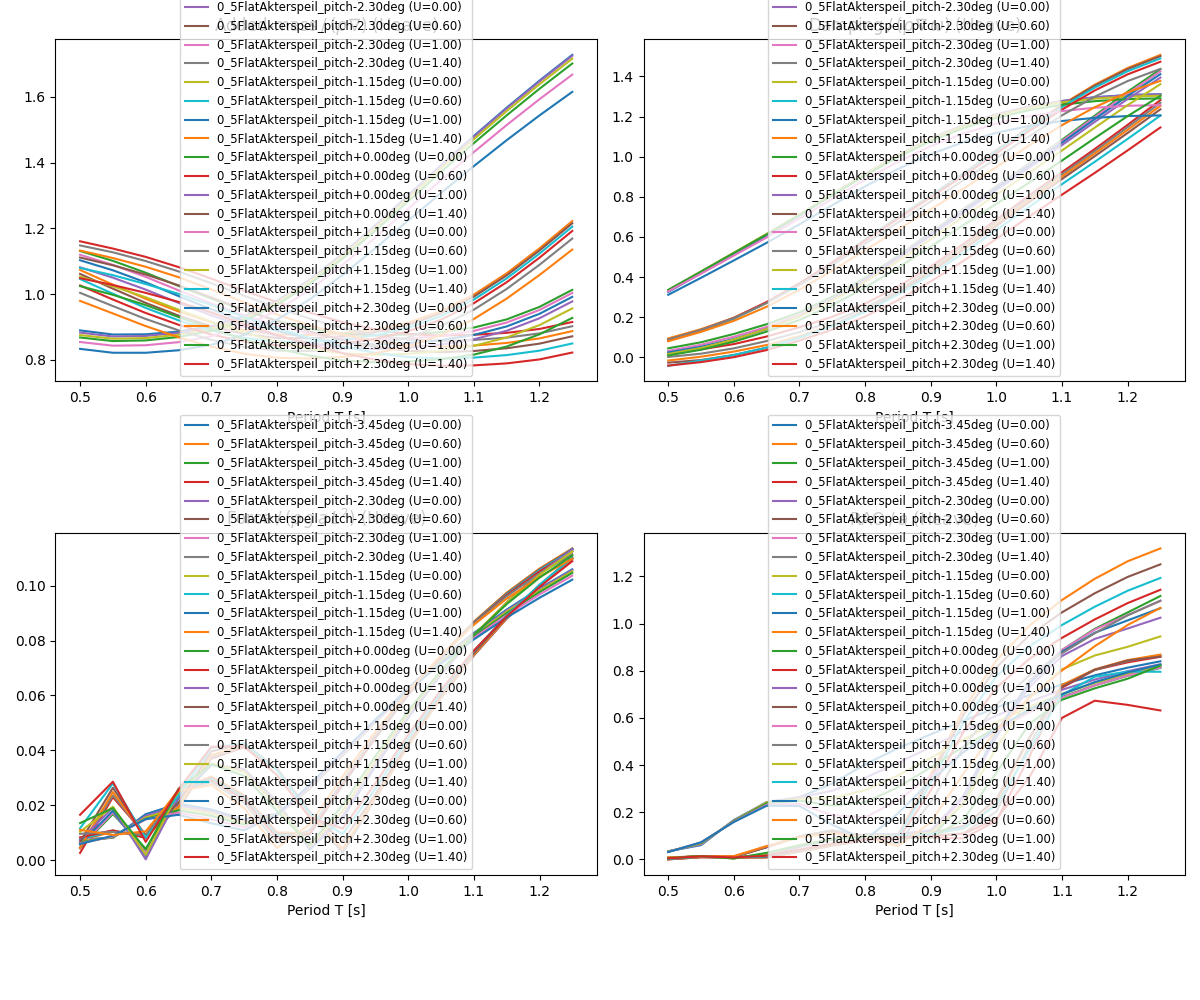

In [ ]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


base_mesh   = "0_5FlatAkterspeil"
rho_water = 1000.0
g         = 9.81
trim_angles = [-3.45, -2.3, -1.15, 0, 1.15, 2.3]   # [deg] pitch about y-axis


speeds      = [0.001, 0.6, 1, 1.4]  

period = np.arange(0.5, 1.3, 0.05)  # [s]
omega = 2 * np.pi / period  # [rad/s]


wave_dir  = float(f"{np.pi:.3f}")   # "3.142"
dof_idx   = 2
n_dofs    = 6


cases       = [f"{base_mesh}_pitch{angle:+.2f}deg" for angle in trim_angles]
print(cases)



weight   = 14.16            
rho      = 1000.0           
g        = 9.81           
wave_amp = 1              
L        = 1.0             

def parse_added_or_damping(case, U, var_name):
    fn    = os.path.join("txt_summaries", f"{case}_added_damping.txt")
    lines = open(fn).read().splitlines()
    tag   = f"## Forward speed: {U:.2f} m/s"
    i0    = next(i for i,l in enumerate(lines) if l.strip().startswith(tag))
    label= "Added Mass" if var_name=="added_mass" else "Radiation Damping"
    i1   = next(i for i in range(i0, len(lines)) if lines[i].strip()==label)+1

    vals, ptr = [], i1
    for _ in omega:
        mat = [list(map(float, lines[ptr+r].split())) for r in range(n_dofs)]
        vals.append(mat[dof_idx][dof_idx])
        ptr += n_dofs + 1
    return np.array(vals)

def parse_vector(case, kind):
    fn        = os.path.join("txt_summaries", f"{case}_{kind}.txt")
    out       = {}
    wd_target = f"{wave_dir:.3f}"
    with open(fn) as f:
        for line in f:
            line = line.strip()
            if not line:    continue
            if line.startswith("# U="):
                U_file = float(line.split("=",1)[1].split()[0])
                U      = next(s for s in speeds
                              if abs(round(s,2)-round(U_file,2))<1e-6)
                out[U] = {}
            elif line.startswith("#"):
                continue
            else:
                parts = line.split()
                w, wd_str = float(parts[0]), parts[1]
                if wd_str!=wd_target:  continue
                vals = [abs(complex(s.replace("+-","-"))) for s in parts[2:]]
                out[U][w] = vals[dof_idx]
    return out

AM  = {c:{U:parse_added_or_damping(c,U,"added_mass") for U in speeds} for c in cases}
RD  = {c:{U:parse_added_or_damping(c,U,"radiation_damping") for U in speeds} for c in cases}
FX  = {c:parse_vector(c,"forces") for c in cases}
RAO = {c:parse_vector(c,"rao")    for c in cases}

fig, axs = plt.subplots(2,2, figsize=(12,10))
axs = axs.flatten()
for case in cases:
    for U in speeds:
        lbl = f"{case} (U={U:.2f})"

        AM_nd = AM[case][U] / weight
        RD_nd = RD[case][U] / (weight * omega)
        axs[0].plot(period, AM_nd, label=lbl)
        axs[1].plot(period, RD_nd, label=lbl)

        w3       = sorted(FX[case][U]);  y3 = np.array([FX[case][U][w] for w in w3])
        Force_nd = y3 / (rho * g * wave_amp * L**2)
        T3       = 2*np.pi/np.array(w3)
        axs[2].plot(*zip(*sorted(zip(T3, Force_nd))), label=lbl)

        w4       = sorted(RAO[case][U]); y4 = np.array([RAO[case][U][w] for w in w4])
        RAO_nd   = y4 / wave_amp
        T4       = 2*np.pi/np.array(w4)
        axs[3].plot(*zip(*sorted(zip(T4, RAO_nd))), label=lbl)

titles = [
    r"Added‐mass / ($\rho\,\nabla$) (Heave)",
    r"Damping / ($\rho\,\nabla\,\omega$) (Heave)",
    r"Force / ($\rho\,g\,a\,L^{2}$) (Heave)",
    r"RAO / $a$ (Heave)",
]
for ax, t in zip(axs, titles):
    ax.set_title(t)
    ax.set_xlabel("Period T [s]")
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

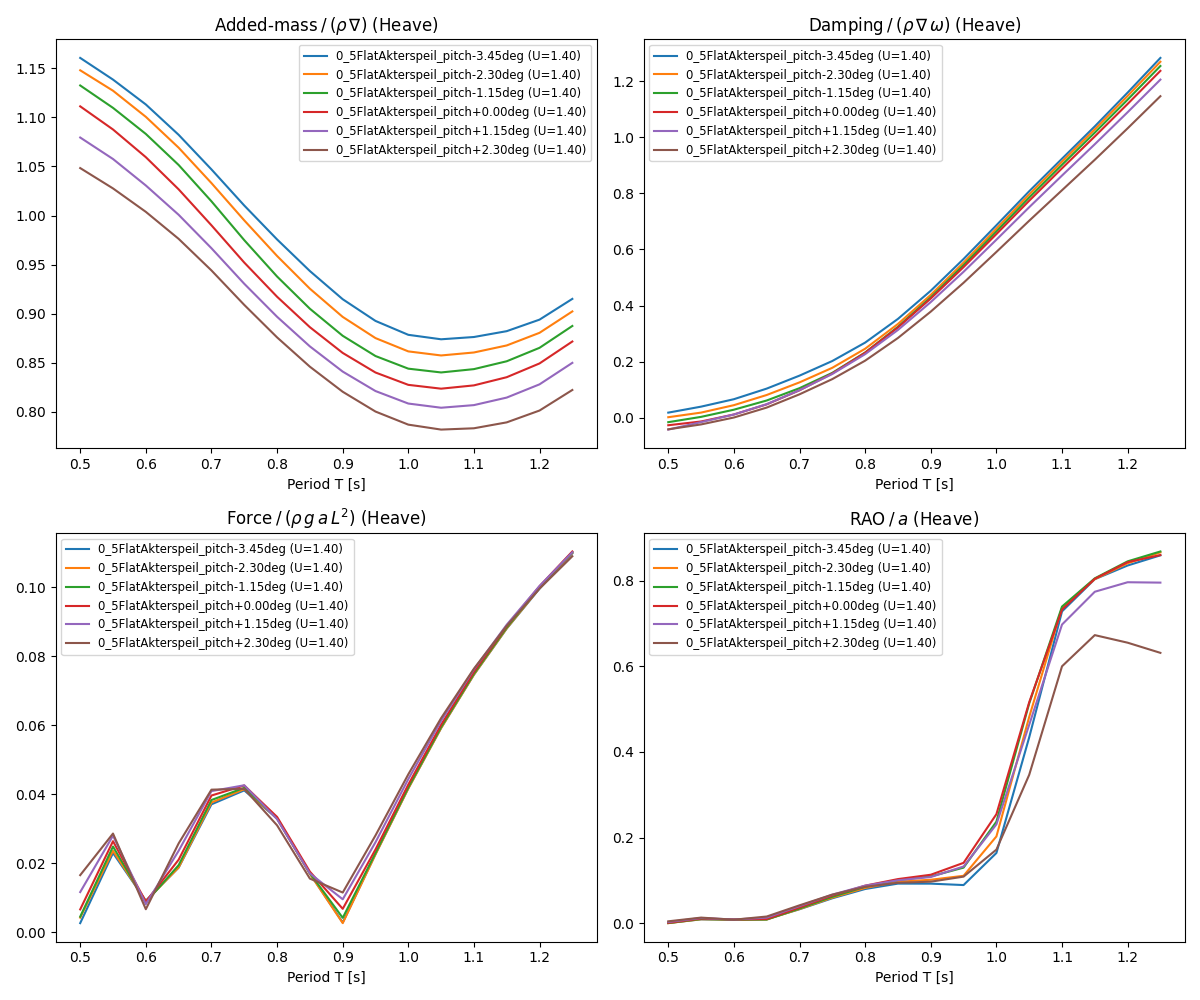

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

selected_U = 1.4 

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for case in cases:
    lbl = f"{case} (U={selected_U:.2f})"

    AM_nd = AM[case][selected_U] / weight
    RD_nd = RD[case][selected_U] / (weight * omega)
    axs[0].plot(period, AM_nd, label=lbl)
    axs[1].plot(period, RD_nd, label=lbl)


    w3 = np.array(sorted(FX[case][selected_U]))
    y3 = np.array([FX[case][selected_U][w] for w in w3])
    Force_nd = y3 / (rho * g * wave_amp * L**2)
    T3 = 2 * np.pi / w3
    idx3 = np.argsort(T3)
    axs[2].plot(T3[idx3], Force_nd[idx3], label=lbl)

    # RAO
    w4 = np.array(sorted(RAO[case][selected_U]))
    y4 = np.array([RAO[case][selected_U][w] for w in w4])
    RAO_nd = y4 / wave_amp
    T4 = 2 * np.pi / w4
    idx4 = np.argsort(T4)
    axs[3].plot(T4[idx4], RAO_nd[idx4], label=lbl)

titles = [
    r"Added‐mass / ($\rho\,\nabla$) (Heave)",
    r"Damping / ($\rho\,\nabla\,\omega$) (Heave)",
    r"Force / ($\rho\,g\,a\,L^{2}$) (Heave)",
    r"RAO / $a$ (Heave)",
]
for ax, title in zip(axs, titles):
    ax.set_title(title)
    ax.set_xlabel("Period T [s]")
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

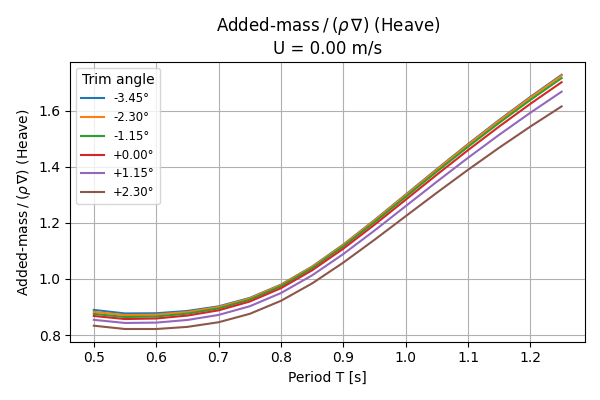

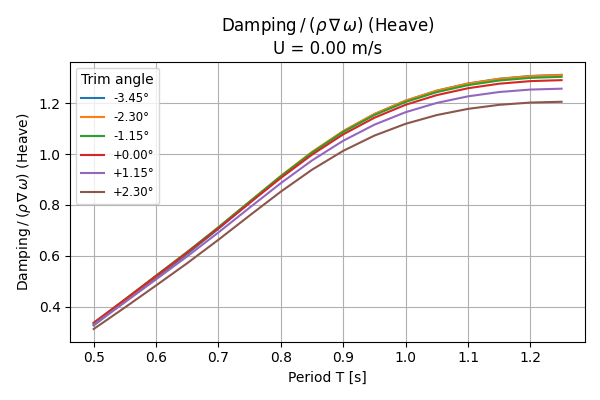

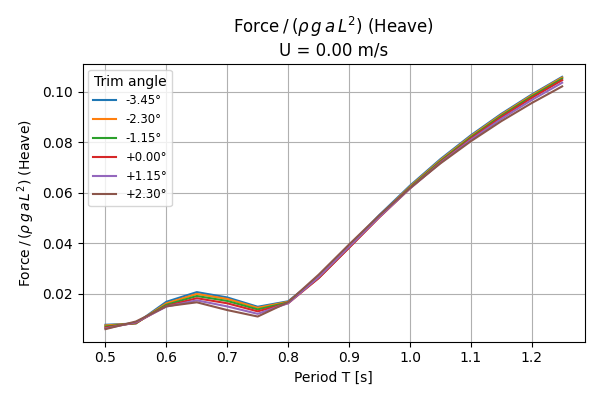

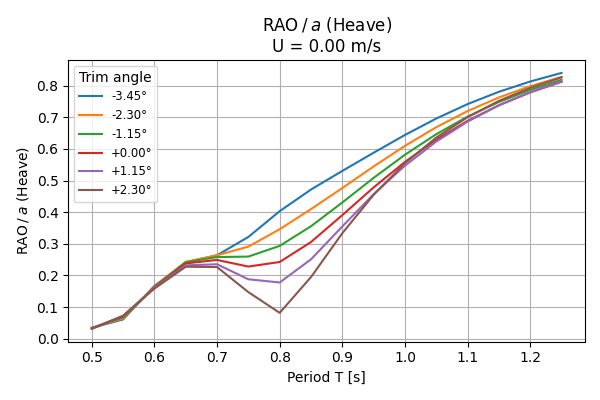

In [ ]:

import os
import matplotlib.pyplot as plt
import numpy as np


selected_U = 0.001   


outdir = "figures_trim"
os.makedirs(outdir, exist_ok=True)


metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": r"Added‐mass / ($\rho\,\nabla$) (Heave)",
        "filename": "added_mass",
        "nd_func": lambda y: y/weight,
        "x": period
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": r"Damping / ($\rho\,\nabla\,\omega$) (Heave)",
        "filename": "radiation_damping",
        "nd_func": lambda y: y/(weight*omega),
        "x": period
    },
    "forces": {
        "data": FX,
        "ylabel": r"Force / ($\rho\,g\,a\,L^{2}$) (Heave)",
        "filename": "excitation_force",
        "nd_func": lambda w,y: y/(rho*g*wave_amp*L**2),
      
    },
    "rao": {
        "data": RAO,
        "ylabel": r"RAO / $a$ (Heave)",
        "filename": "rao",
        "nd_func": lambda w,y: y/wave_amp,
       
    },
}

for key, info in metrics.items():
    fig, ax = plt.subplots(figsize=(6,4))
    for angle, case in zip(trim_angles, cases):
        angle_str = f"{angle:+.2f}°"
        D = info["data"][case][selected_U]
        if key in ("added_mass", "radiation_damping"):
            x = info["x"]
            y = info["nd_func"](D)
        else:
            
            w = np.array(sorted(D))
            y_raw = np.array([D[wv] for wv in w])
            x = 2*np.pi / w
            idx = np.argsort(x)
            y = info["nd_func"](w, y_raw)[idx]
            x = x[idx]
        ax.plot(x, y, label=angle_str)
    ax.set_xlabel("Period T [s]")
    ax.set_ylabel(info["ylabel"])
    ax.set_title(f"{info['ylabel']}\nU = {selected_U:.2f} m/s")
    ax.legend(title="Trim angle", fontsize="small")
    ax.grid(True)
    fig.tight_layout()

    fname = os.path.join(outdir, f"{info['filename']}_U{selected_U:.2f}.png")
    fig.savefig(fname, dpi=200)
    plt.show()

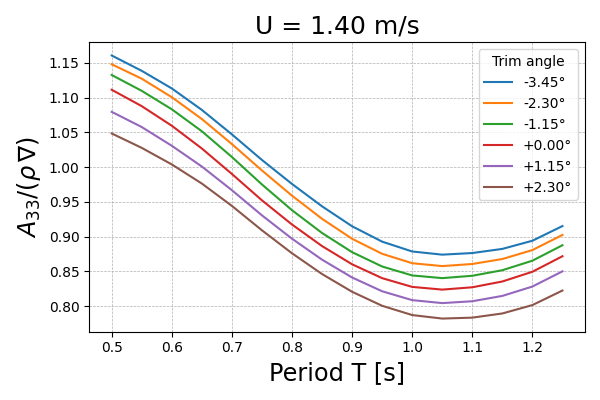

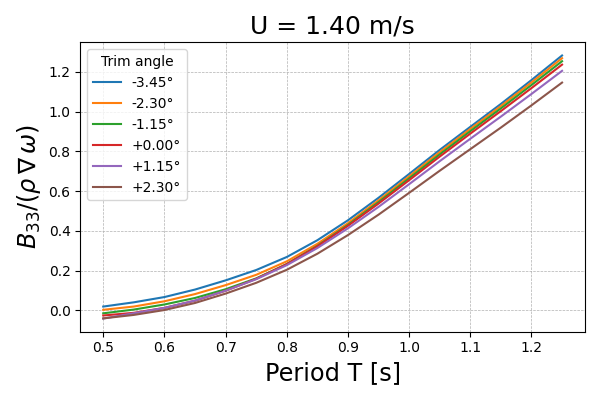

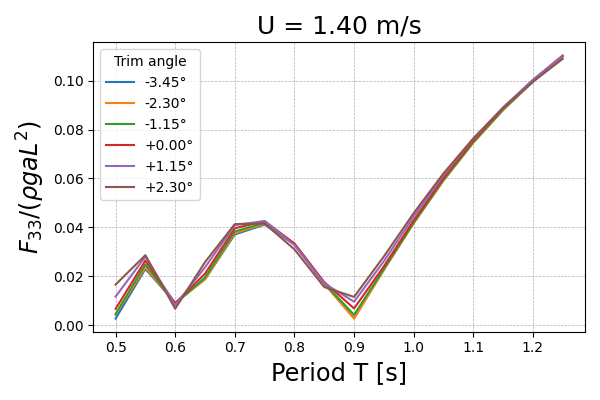

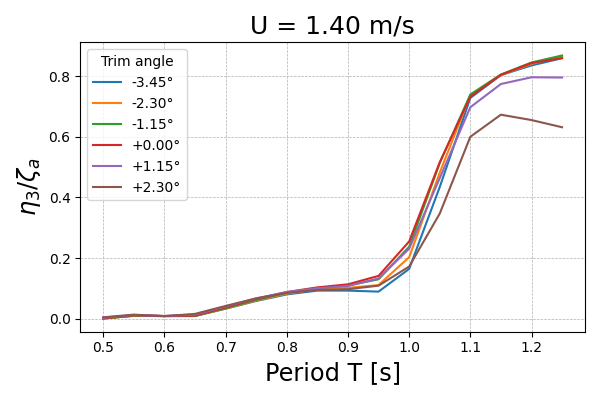

In [ ]:

import os
import matplotlib.pyplot as plt
import numpy as np


selected_U = 1.4   

# create output folder for figures
outdir = "figures_trim_NY"
os.makedirs(outdir, exist_ok=True)

# mapping of metrics to their data dicts, y‐labels and filenames
metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": r"$A_{33}/(\rho\,\nabla)$",
        "filename": "added_mass",
        "nd_func": lambda y: y/weight,
        "x": period
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": r"$B_{33}/(\rho\,\nabla\,\omega)$",
        "filename": "radiation_damping",
        "nd_func": lambda y: y/(weight*omega),
        "x": period
    },
    "forces": {
        "data": FX,
        "ylabel": r"$F_{33}/(\rho g a L^2)$",
        "filename": "excitation_force",
        "nd_func": lambda w, y: y/(rho*g*wave_amp*L**2),
    },
    "rao": {
        "data": RAO,
        "ylabel": r"$\eta_3/\zeta_a$",
        "filename": "rao",
        "nd_func": lambda w, y: y/wave_amp,
    },
}

for key, info in metrics.items():
    fig, ax = plt.subplots(figsize=(6,4))
    for angle, case in zip(trim_angles, cases):
        D = info["data"][case][selected_U]
        if key in ("added_mass", "radiation_damping"):
            x = info["x"]
            y = info["nd_func"](D)
        else:
            w   = np.array(sorted(D))
            y0  = np.array([D[w0] for w0 in w])
            T   = 2*np.pi / w
            idx = np.argsort(T)
            x   = T[idx]
            y   = info["nd_func"](w[idx], y0[idx])
        ax.plot(x, y, lw=1.5, label=f"{angle:+.2f}°")

    ax.set_title(f"U = {selected_U:.2f} m/s", fontsize=18)
    ax.set_xlabel("Period T [s]", fontsize="xx-large")
    ax.set_ylabel(info["ylabel"], fontsize="xx-large")
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.legend(title="Trim angle", fontsize="medium", loc="best")
    fig.tight_layout()

    fname = os.path.join(outdir, f"{info['filename']}_U{selected_U:.2f}.png")
    fig.savefig(fname, dpi=300)
    plt.show()

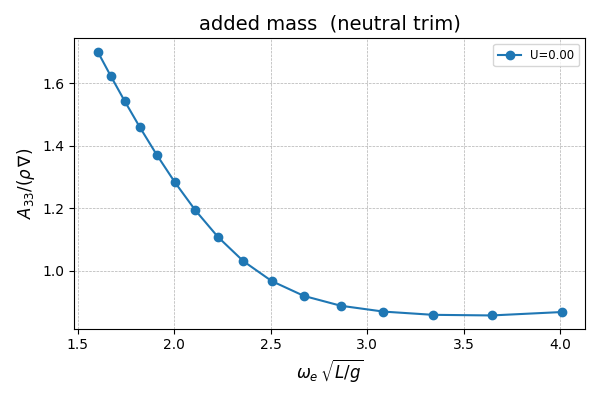

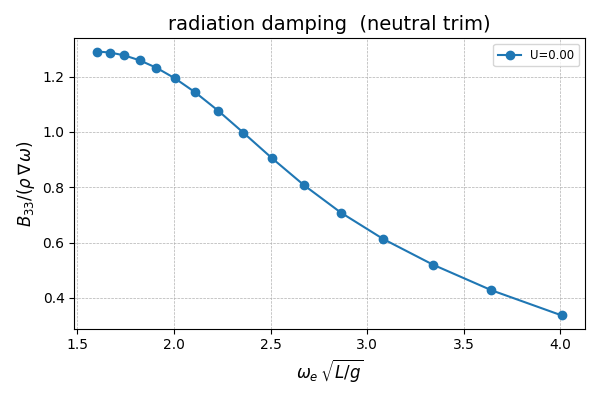

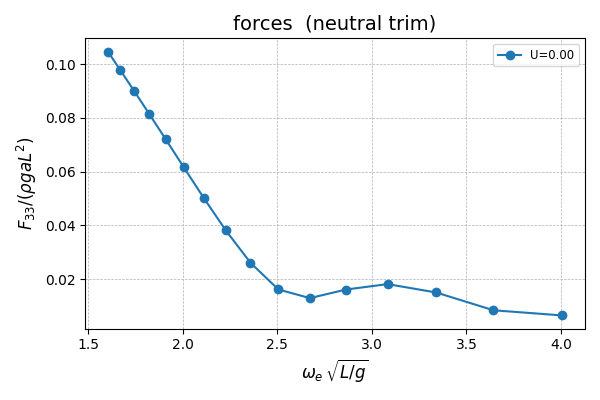

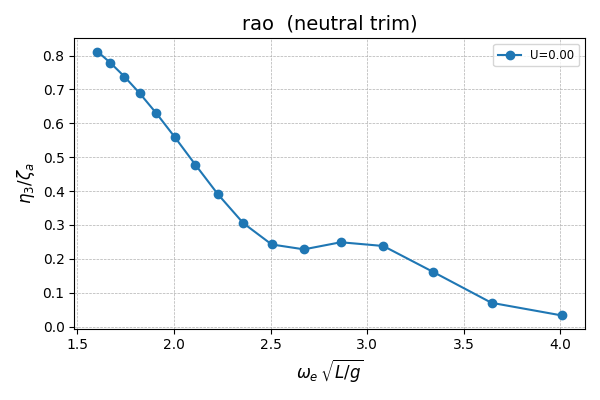

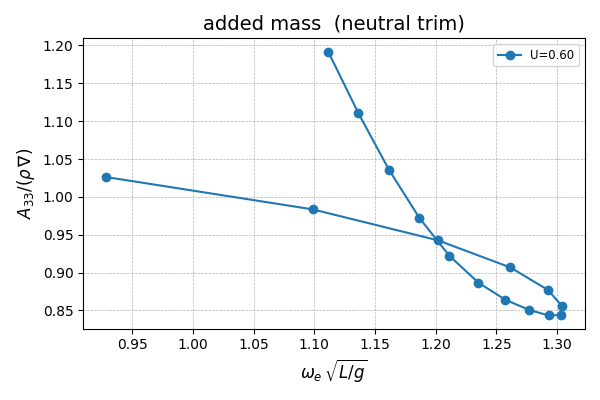

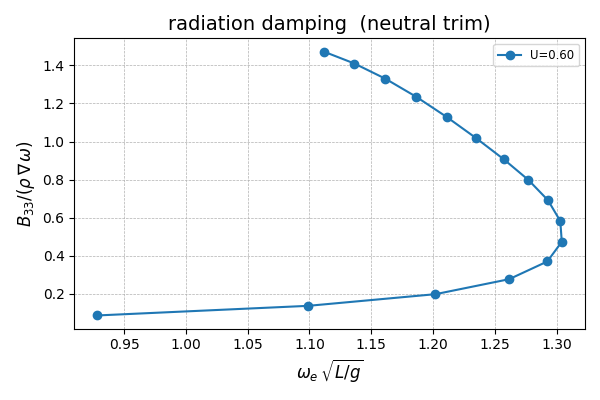

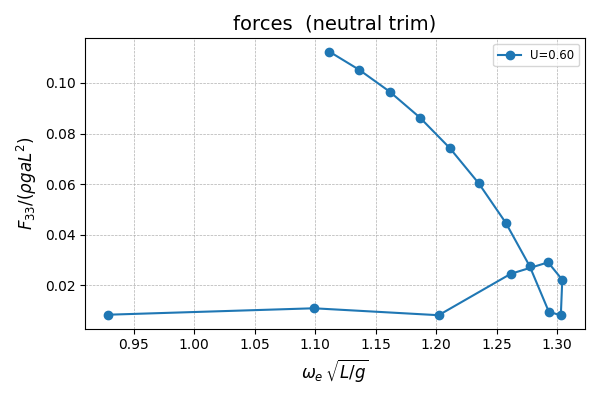

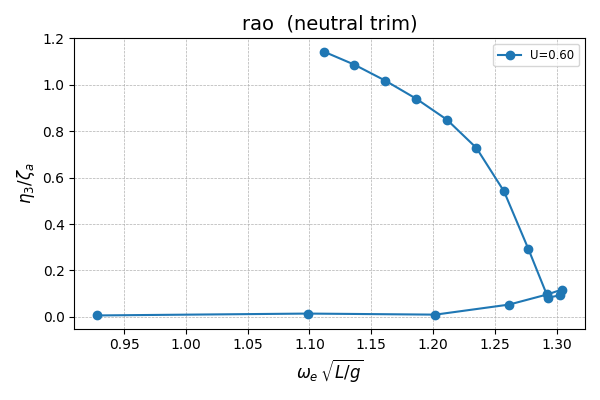

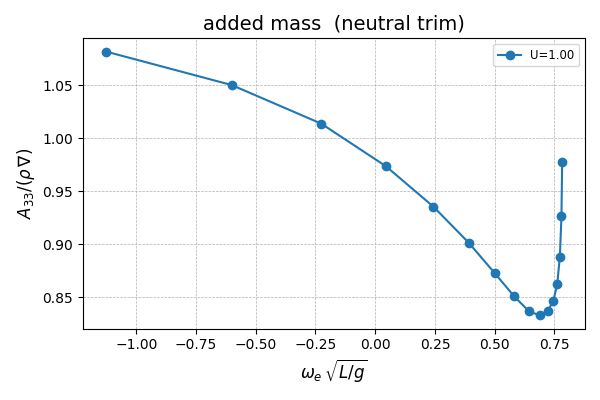

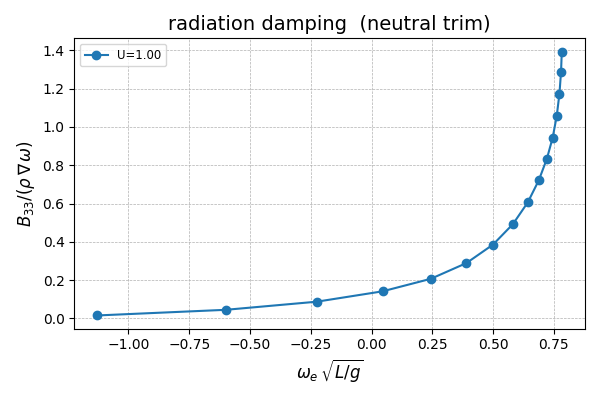

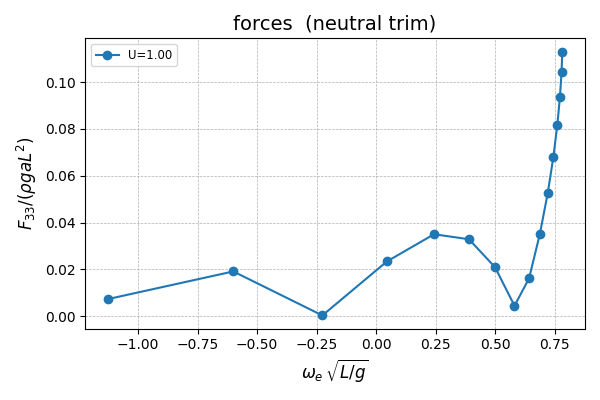

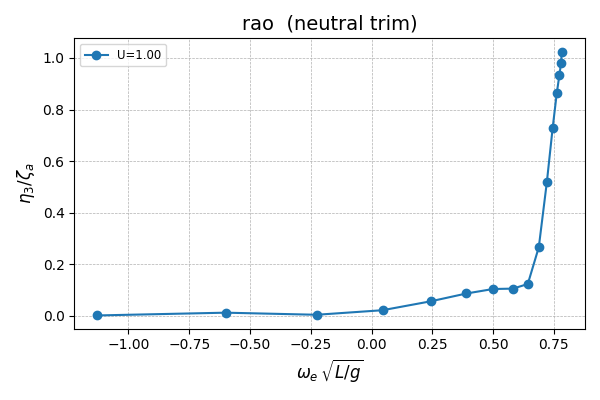

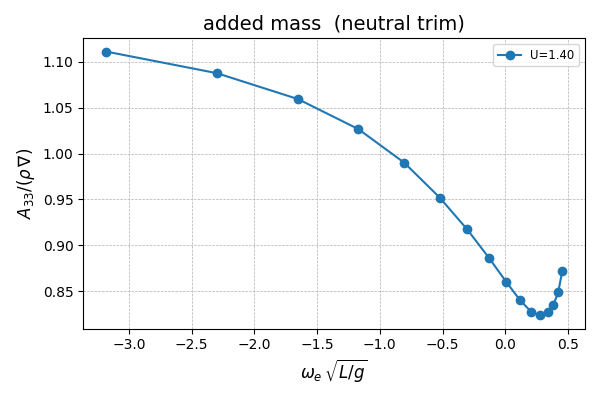

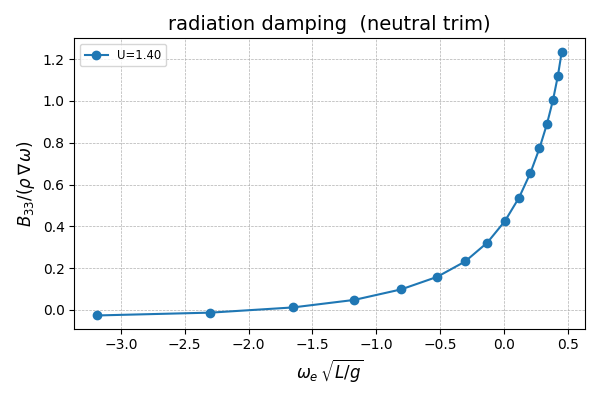

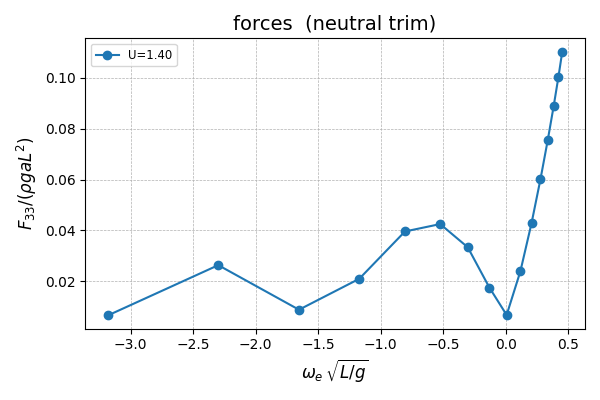

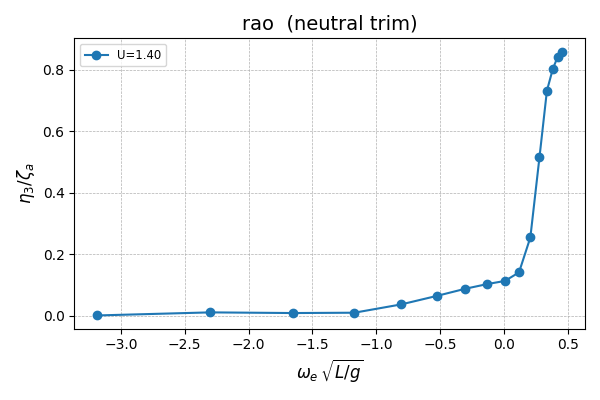

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt


g      = 9.81
L      = 1.0    # characteristic length [m]
sqrtLg = np.sqrt(L/g)

# only the neutral‐trim case
case0 = f"{base_mesh}_pitch{0:+.2f}deg"

outdir = "figures_neutral_encounter"
os.makedirs(outdir, exist_ok=True)


metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": r"$A_{33}/(\rho\,\nabla)$",
        "filename": "A33",
        "nd":    lambda y, ω=None: y/weight
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": r"$B_{33}/(\rho\,\nabla\,\omega)$",
        "filename": "B33",
        "nd":    lambda y, ω=None: y/(weight*omega)
    },
    "forces": {
        "data": FX,
        "ylabel": r"$F_{33}/(\rho g a L^2)$",
        "filename": "F33",
        "nd":    lambda ω, y: y/(rho*g*wave_amp*L**2)
    },
    "rao": {
        "data": RAO,
        "ylabel": r"$\eta_3/\zeta_a$",
        "filename": "RAO3",
        "nd":    lambda ω, y: y/wave_amp
    },
}

for U in speeds:
    for key, info in metrics.items():
        fig, ax = plt.subplots(figsize=(6,4))

        if key in ("added_mass", "radiation_damping"):
            # use array omega from above
            ω    = omega
            k    = ω**2 / g
            ω_e  = ω - k*U
            x_nd = ω_e * sqrtLg
            y_nd = info["nd"](info["data"][case0][U])
            ax.plot(x_nd, y_nd, '-o', label=f"U={U:.2f}")
        else:
            D    = info["data"][case0][U]
            ωs   = np.array(sorted(D))
            k    = ωs**2 / g
            ω_e  = ωs - k*U
            x_nd = ω_e * sqrtLg
            y0   = np.array([D[w] for w in ωs])
            y_nd = info["nd"](ωs, y0)
            ax.plot(x_nd, y_nd, '-o', label=f"U={U:.2f}")

        ax.set_title(f"{key.replace('_',' ')}  (neutral trim)", fontsize=14)
        ax.set_xlabel(r"$\omega_e\,\sqrt{L/g}$", fontsize=12)
        ax.set_ylabel(info["ylabel"], fontsize=12)
        ax.grid(True, ls="--", lw=0.5)
        ax.legend(fontsize="small", loc="best")
        fig.tight_layout()

        fname = f"{info['filename']}_neutral_U{U:.2f}.png"
        #fig.savefig(os.path.join(outdir, fname), dpi=200)
        plt.show()

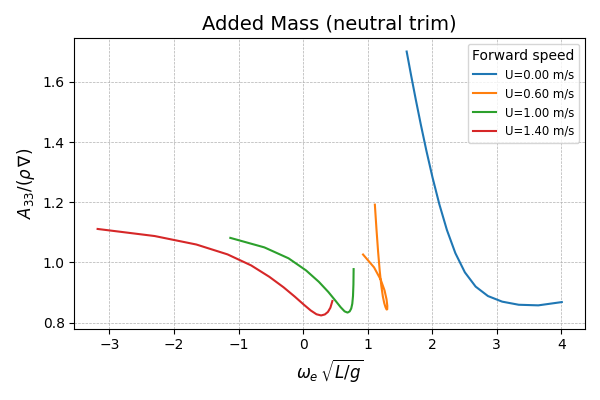

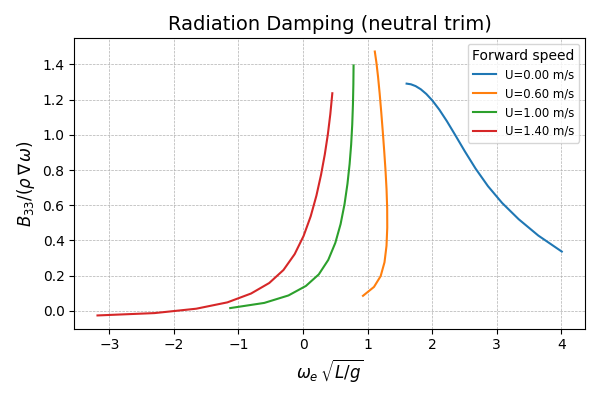

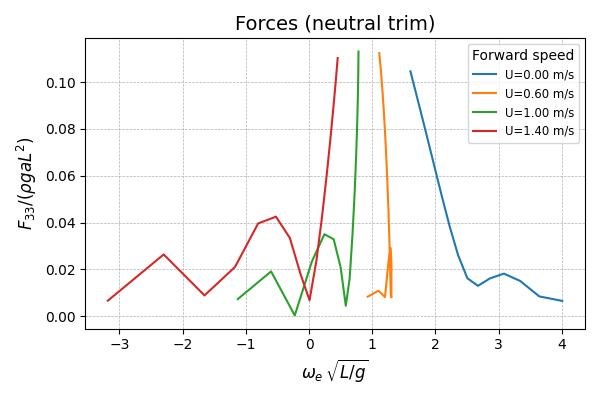

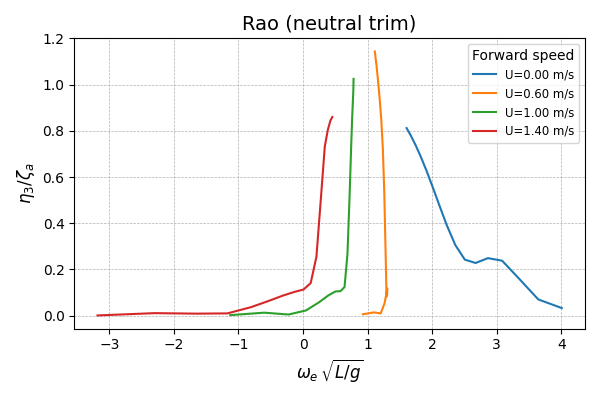

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt


g      = 9.81
L      = 1.0    # characteristic length [m]
sqrtLg = np.sqrt(L/g)


case0 = f"{base_mesh}_pitch{0:+.2f}deg"


outdir = "figures_neutral_encounter"
os.makedirs(outdir, exist_ok=True)

metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": r"$A_{33}/(\rho\,\nabla)$",
        "filename": "A33"
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": r"$B_{33}/(\rho\,\nabla\,\omega)$",
        "filename": "B33"
    },
    "forces": {
        "data": FX,
        "ylabel": r"$F_{33}/(\rho g a L^2)$",
        "filename": "F33"
    },
    "rao": {
        "data": RAO,
        "ylabel": r"$\eta_3/\zeta_a$",
        "filename": "RAO3"
    },
}

for key, info in metrics.items():
    fig, ax = plt.subplots(figsize=(6,4))
    for U in speeds:
        if key in ("added_mass", "radiation_damping"):
            ω    = omega
            k    = ω**2 / g
            ω_e  = ω - k*U
            x_nd = ω_e * sqrtLg
            y_raw = info["data"][case0][U]
            if key == "added_mass":
                y_nd = y_raw / weight
            else:
                y_nd = y_raw / (weight * omega)
        else:
            D    = info["data"][case0][U]
            ωs   = np.array(sorted(D))
            k    = ωs**2 / g
            ω_e  = ωs - k*U
            x_nd = ω_e * sqrtLg
            y0   = np.array([D[w] for w in ωs])
            if key == "forces":
                y_nd = y0/(rho*g*wave_amp*L**2)
            else:  # "rao"
                y_nd = y0/wave_amp
        ax.plot(x_nd, y_nd, '-', label=f"U={U:.2f} m/s")

    ax.set_title(f"{key.replace('_',' ').title()} (neutral trim)", fontsize=14)
    ax.set_xlabel(r"$\omega_e\,\sqrt{L/g}$", fontsize=12)
    ax.set_ylabel(info["ylabel"], fontsize=12)
    ax.grid(True, ls="--", lw=0.5)
    ax.legend(title="Forward speed", fontsize="small", loc="best")
    fig.tight_layout()

    fname = os.path.join(outdir, f"{info['filename']}_neutral_allU.png")
    #fig.savefig(fname, dpi=200)
    plt.show()

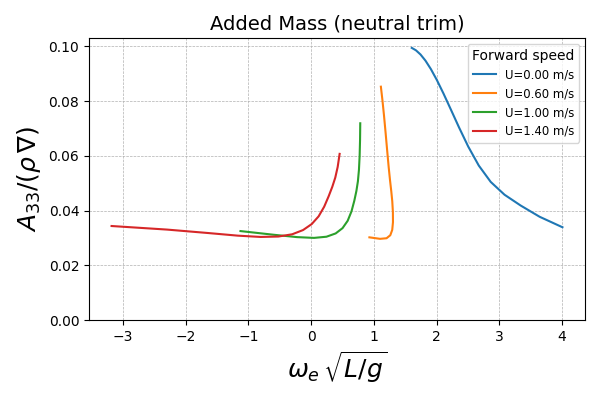

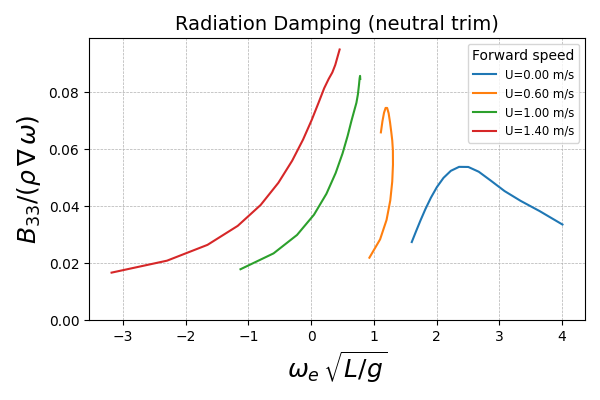

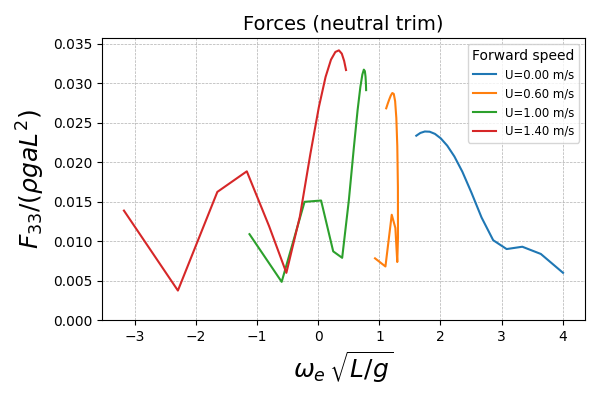

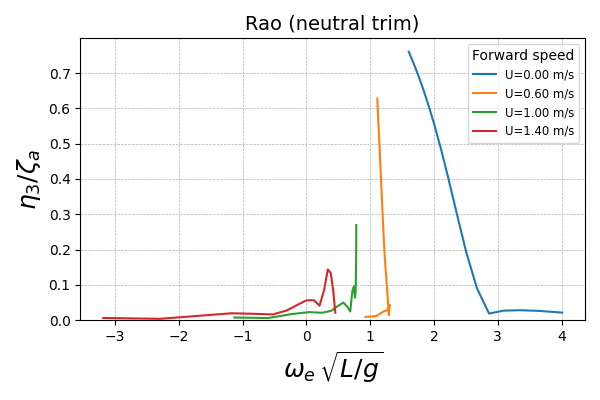

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt


g      = 9.81
L      = 1.0       # characteristic length [m]
sqrtLg = np.sqrt(L/g)

# neutral trim case
case0 = f"{base_mesh}_pitch{0:+.2f}deg"

# output folder
outdir = "figures_neutral_encounter_heave"
os.makedirs(outdir, exist_ok=True)

# metrics config
metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": r"$A_{33}/(\rho\,\nabla)$",
        "filename": "A33"
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": r"$B_{33}/(\rho\,\nabla\,\omega)$",
        "filename": "B33"
    },
    "forces": {
        "data": FX,
        "ylabel": r"$F_{33}/(\rho g a L^2)$",
        "filename": "F33"
    },
    "rao": {
        "data": RAO,
        "ylabel": r"$\eta_3/\zeta_a$",
        "filename": "RAO3"
    },
}

for key, info in metrics.items():
    fig, ax = plt.subplots(figsize=(6,4))
    for U in speeds:
        if key in ("added_mass", "radiation_damping"):
            ω    = omega
            k    = ω**2 / g
            ω_e  = ω - k*U
            x_nd = ω_e * sqrtLg
            y_raw = info["data"][case0][U]
            if key == "added_mass":
                y_nd = y_raw / weight
            else:
                y_nd = y_raw / (weight * omega)
        else:
            D    = info["data"][case0][U]
            ωs   = np.array(sorted(D))
            k    = ωs**2 / g
            ω_e  = ωs - k*U
            x_nd = ω_e * sqrtLg
            y0   = np.array([D[w] for w in ωs])
            if key == "forces":
                y_nd = y0/(rho*g*wave_amp*L**2)
            else:
                y_nd = y0/wave_amp
        ax.plot(x_nd, y_nd, '-', label=f"U={U:.2f} m/s")

    ax.set_title(f"{key.replace('_',' ').title()} (neutral trim)", fontsize=14)
    ax.set_xlabel(r"$\omega_e\,\sqrt{L/g}$", fontsize=18)
    ax.set_ylabel(info["ylabel"], fontsize=18)
    ax.grid(True, ls="--", lw=0.5)


    ax.set_ylim(bottom=0)

    ax.legend(title="Forward speed", fontsize="small", loc="best")
    fig.tight_layout()

    fname = os.path.join(outdir, f"{info['filename']}_neutral_allU.png")
    fig.savefig(fname, dpi=200)
    plt.show()

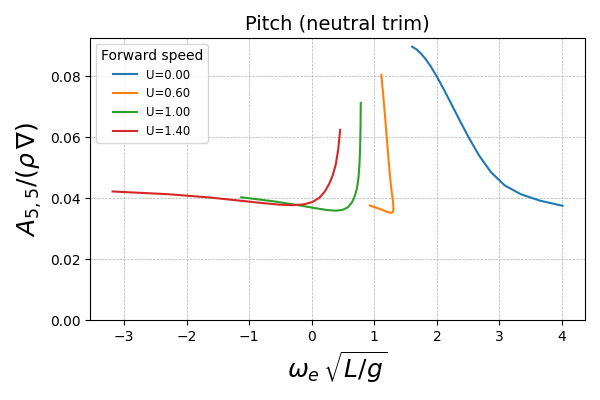

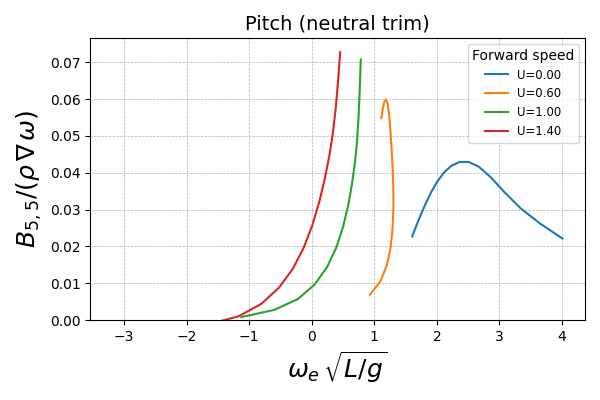

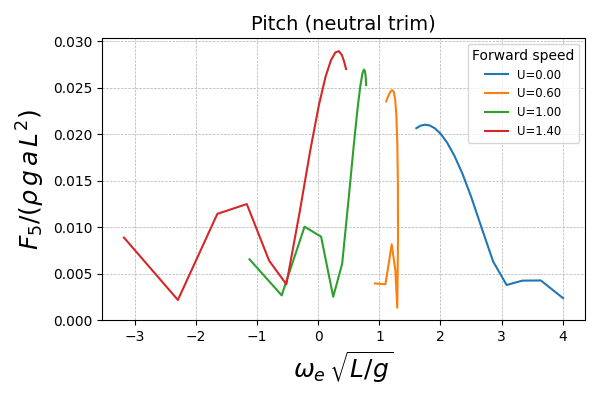

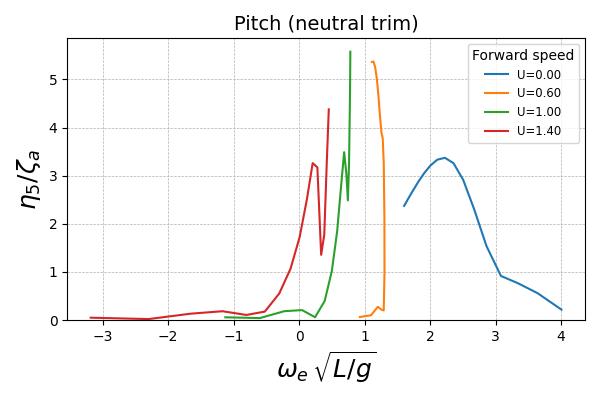

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt


dof_idx  = 4                    # 0=surge,1=sway,2=heave,3=roll,4=pitch,5=yaw
dof_name = "Pitch"


L      = 1.0                   # characteristic length [m]
sqrtLg = np.sqrt(L/g)

# recompute data for the selected DOF
AM  = {c:{U:parse_added_or_damping(c,U,"added_mass")       for U in speeds} for c in cases}
RD  = {c:{U:parse_added_or_damping(c,U,"radiation_damping")for U in speeds} for c in cases}
FX  = {c:parse_vector(c,"forces") for c in cases}
RAO = {c:parse_vector(c,"rao")    for c in cases}

# neutral‐trim case (pitch=0°)
case0 = f"{base_mesh}_pitch{0:+.2f}deg"

# output folder
outdir = f"figures_neutral_encounter_{dof_name.lower()}"
os.makedirs(outdir, exist_ok=True)


metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": fr"$A_{{{dof_idx+1},{dof_idx+1}}}/(\rho\,\nabla)$",
        "filename": "A_pitch",
        "norm":    lambda y, ω=None: y/weight
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": fr"$B_{{{dof_idx+1},{dof_idx+1}}}/(\rho\,\nabla\,\omega)$",
        "filename": "B_pitch",
        "norm":    lambda y, ω=None: y/(weight*omega)
    },
    "forces": {
        "data": FX,
        "ylabel": fr"$F_{{{dof_idx+1}}}/(\rho\,g\,a\,L^2)$",
        "filename": "F_pitch",
        "norm":    lambda ω, y: y/(rho*g*wave_amp*L**2)
    },
    "rao": {
        "data": RAO,
        "ylabel": fr"$\eta_{{{dof_idx+1}}}/\zeta_a$",
        "filename": "RAO_pitch",
        "norm":    lambda ω, y: y/wave_amp
    },
}

for key, info in metrics.items():
    fig, ax = plt.subplots(figsize=(6,4))
    for U in speeds:
        if key in ("added_mass","radiation_damping"):
            ω   = omega
            k   = ω**2 / g
            ω_e = ω - k*U
            x   = ω_e * sqrtLg
            y   = info["norm"]( info["data"][case0][U] )
        else:
            D   = info["data"][case0][U]
            ωs  = np.array(sorted(D))
            k   = ωs**2 / g
            ω_e = ωs - k*U
            x   = ω_e * sqrtLg
            y0  = np.array([D[w] for w in ωs])
            y   = info["norm"](ωs, y0)
        ax.plot(x, y, '-', label=f"U={U:.2f}")

    ax.set_title(f"{dof_name} (neutral trim)", fontsize=14)
    ax.set_xlabel(r"$\omega_e\,\sqrt{L/g}$", fontsize=18)
    ax.set_ylabel(info["ylabel"], fontsize=18)
    ax.grid(True, ls="--", lw=0.5)
    ax.set_ylim(bottom=0)
    ax.legend(title="Forward speed", fontsize="small", loc="best")
    fig.tight_layout()

    fname = os.path.join(outdir, f"{info['filename']}_allU.png")
    fig.savefig(fname, dpi=200)
    plt.show()

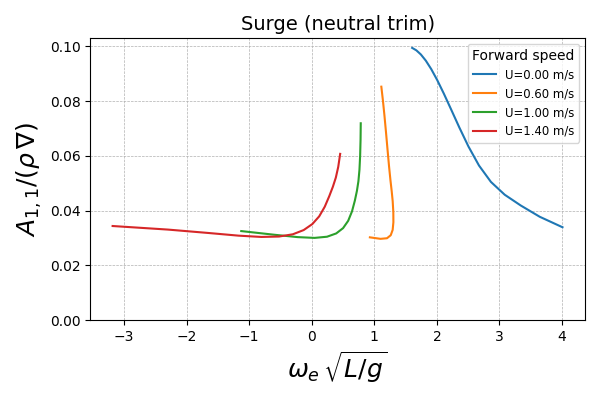

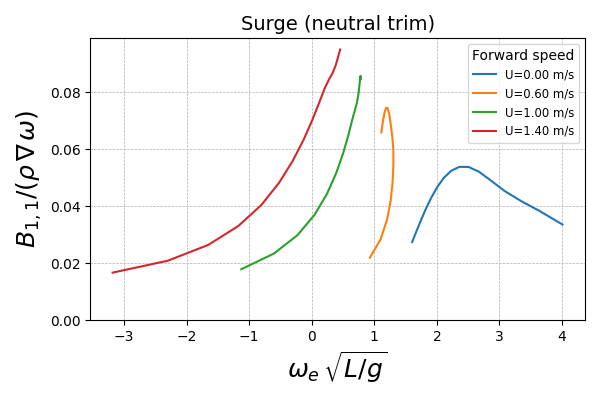

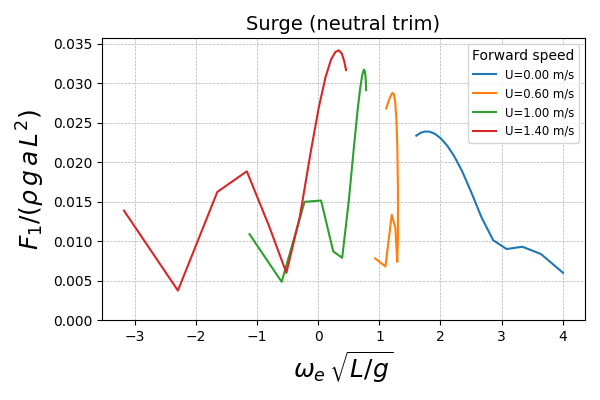

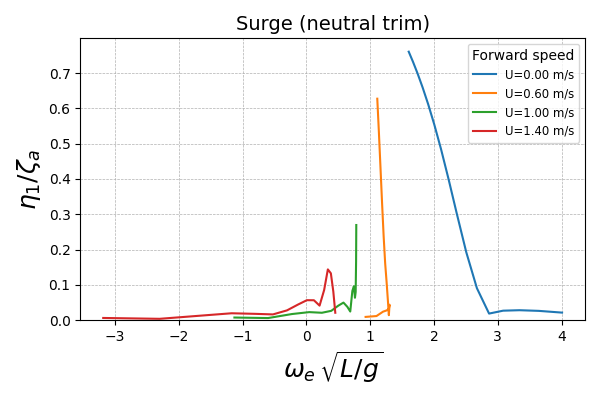

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt


dof_idx  = 0                    # 0=surge,1=sway,2=heave,3=roll,4=pitch,5=yaw
dof_name = "Surge"


g      = 9.81
L      = 1.0                   # characteristic length [m]
sqrtLg = np.sqrt(L/g)


AM  = {c:{U:parse_added_or_damping(c,U,"added_mass")       for U in speeds} for c in cases}
RD  = {c:{U:parse_added_or_damping(c,U,"radiation_damping")for U in speeds} for c in cases}
FX  = {c:parse_vector(c,"forces") for c in cases}
RAO = {c:parse_vector(c,"rao")    for c in cases}


case0 = f"{base_mesh}_pitch{0:+.2f}deg"

# output folder
outdir = f"figures_neutral_encounter_{dof_name.lower()}"
os.makedirs(outdir, exist_ok=True)

# metrics configuration
metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": fr"$A_{{{dof_idx+1},{dof_idx+1}}}/(\rho\,\nabla)$",
        "filename": "A_surge",
        "norm":    lambda y, ω=None: y/weight
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": fr"$B_{{{dof_idx+1},{dof_idx+1}}}/(\rho\,\nabla\,\omega)$",
        "filename": "B_surge",
        "norm":    lambda y, ω=None: y/(weight*omega)
    },
    "forces": {
        "data": FX,
        "ylabel": fr"$F_{{{dof_idx+1}}}/(\rho\,g\,a\,L^2)$",
        "filename": "F_surge",
        "norm":    lambda ω, y: y/(rho*g*wave_amp*L**2)
    },
    "rao": {
        "data": RAO,
        "ylabel": fr"$\eta_{{{dof_idx+1}}}/\zeta_a$",
        "filename": "RAO_surge",
        "norm":    lambda ω, y: y/wave_amp
    },
}

for key, info in metrics.items():
    fig, ax = plt.subplots(figsize=(6,4))
    for U in speeds:
        if key in ("added_mass","radiation_damping"):
            ω   = omega
            k   = ω**2 / g
            ω_e = ω - k*U
            x   = ω_e * sqrtLg
            y   = info["norm"]( info["data"][case0][U] )
        else:
            D   = info["data"][case0][U]
            ωs  = np.array(sorted(D))
            k   = ωs**2 / g
            ω_e = ωs - k*U
            x   = ω_e * sqrtLg
            y0  = np.array([D[w] for w in ωs])
            y   = info["norm"](ωs, y0)
        ax.plot(x, y, '-', label=f"U={U:.2f} m/s")

    ax.set_title(f"{dof_name} (neutral trim)", fontsize=14)
    ax.set_xlabel(r"$\omega_e\,\sqrt{L/g}$", fontsize=18)
    ax.set_ylabel(info["ylabel"], fontsize=18)
    ax.grid(True, ls="--", lw=0.5)
    ax.set_ylim(bottom=0)
    ax.legend(title="Forward speed", fontsize="small", loc="best")
    fig.tight_layout()

    fname = os.path.join(outdir, f"{info['filename']}_allU.png")
    fig.savefig(fname, dpi=200)
    plt.show()